In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from copy import deepcopy
from collections import defaultdict

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []
dir = 'altered_pathways'
for experiment in list(os.listdir(dir)):
    if experiment == '.DS_Store': continue
    res_path = os.path.join(dir, experiment, 'results')
    res_file = open(res_path, 'rb')
    results = pickle.load(res_file)
    res_file.close()
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', results, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        

Specie:  L expected result:  decreased  normal final:  0.00046968807976058855  altered final:  7.442257566299889e-05
confidence interval:  [0.00025447801369008204, 0.0003926688323819399]
deltas coming from simulation:  [-0.00039526550409758963, 0.6652705293656094]
Specie:  LR expected result:  increased  normal final:  9.778037760533953e-06  altered final:  0.0001372838661664257
confidence interval:  [0.9879605831554382, 0.9900685362029354]
deltas coming from simulation:  [0.00012750582840589174, 0.1304002209119399]
Specie:  R expected result:  decreased  normal final:  0.003469688079760587  altered final:  0.003074422575663001
confidence interval:  [0.00025447801369008204, 0.0003926688323819399]
deltas coming from simulation:  [-0.00039526550409758584, 0.012865283164037455]
Specie:  CA expected result:  decreased  normal final:  29.99997946613085  altered final:  29.999711706652608
confidence interval:  [0.2653985094350749, 0.27530356586526206]
deltas coming from simulation:  [-0.0002

In [3]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  20  correct:  20  uncertain:  0  true pos:  10  true neg:  10  false_pos:  0 false neg:  0


In [4]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [2]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) >= 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [5]:
convert_sbml_to_network('BIOMD0000000629.xml')

number reactions 2
number species 5


In [6]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [7]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    critical_reactions = []
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        print('Considering reaction: ', reaction.getId(), ' value of i: ', i)
        if reaction.getId() in critical_reactions :
            kinetic_law = reaction.getKineticLaw()
            num_parameters = kinetic_law.getNumParameters()
            if reaction.getId() == 'v2':
                print('Skipping')
                i+= 2
            else:
                i+= 1
            continue
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            print('altering: ', description['reactions'][i][0], ' from sbml: ', reaction.getId(), parameter.getId())

            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000629.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [8]:
generate_test_set('BIOMD0000000629.xml', description)

Considering reaction:  LR_complx  value of i:  0
altering:  LR_complx  from sbml:  LR_complx k1
altering:  LR_complxrevert  from sbml:  LR_complx k2
Considering reaction:  LRCA_complx  value of i:  2
altering:  LRCA_complx  from sbml:  LRCA_complx k1
altering:  LRCA_complxrevert  from sbml:  LRCA_complx k2


In [9]:
description_path = 'altered_pathways2/reaction1/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['L', 'LR', 'R', 'CA', 'LRCA'],
 'reactions': [['LR_complx', 0, 1],
  ['LR_complxrevert', 0, 1],
  ['LRCA_complx', 0, 1],
  ['LRCA_complxrevert', 0, 1]],
 'connections': [['L', 'LR_complx'],
  ['LR_complxrevert', 'L'],
  ['R', 'LR_complx'],
  ['LR_complxrevert', 'R'],
  ['LR_complx', 'LR'],
  ['LR', 'LR_complxrevert'],
  ['LR', 'LRCA_complx'],
  ['LRCA_complxrevert', 'LR'],
  ['CA', 'LRCA_complx'],
  ['LRCA_complxrevert', 'CA'],
  ['LRCA_complx', 'LRCA'],
  ['LRCA', 'LRCA_complxrevert']],
 'altered': 'LR_complxrevert'}

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000629.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 297.0
Converged at time 33.0
Specie:  L expected result:  increased  normal final:  0.00046969143093621765  altered final:  0.0004996752359542361
confidence interval:  [0.998932400010699, 0.9993162494059276]
deltas coming from simulation:  [2.998380501801842e-05, 0]
Specie:  LR expected result:  decreased  normal final:  9.777080453816326e-06  altered final:  1.0491259502334414e-07
confidence interval:  [0.015019328281659408, 0.018313708196792112]
deltas coming from simulation:  [-9.672167858792982e-06, 0]
Specie:  R expected result:  increased  normal final:  0.003469691430936217  altered final:  0.003499675235954233
confidence interval:  [0.998932400010699, 0.9993162494059276]
deltas coming from simulation:  [2.9983805018016143e-05, 0]
Specie:  CA expected result:  increased  normal final:  29.999979468510748  altered final:  29.99999978014801
confidence interval:  [0.7208126107963034, 0.7300709936973266]
deltas coming from simulation:  [2.0311637261016813e-05, 0]
S

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  1.0


In [4]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 198,
 'uncertain_species': 3,
 'correct_species': 169,
 'true_positives': 83,
 'false_positives': 23,
 'false_negatives': 16,
 'true_negatives': 86}

In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  20  correct:  20  uncertain:  0  true pos:  10  true neg:  10  false_pos:  0 false neg:  0


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [6]:
description

{'species': ['z', 'e', 'w', 'ez'],
 'reactions': [['v1', 0, 1], ['v2', 0, 1], ['v2revert', 0, 1], ['v3', 0, 1]],
 'connections': [['z', 'v1'],
  ['v1', 'w'],
  ['v1', 'e'],
  ['z', 'v2'],
  ['v2revert', 'z'],
  ['e', 'v2'],
  ['v2revert', 'e'],
  ['v2', 'ez'],
  ['ez', 'v2revert'],
  ['ez', 'v3'],
  ['v3', 'w'],
  ['v3', 'e']],
 'altered': ''}

In [7]:
description['altered'] = 'v1'
description

{'species': ['z', 'e', 'w', 'ez'],
 'reactions': [['v1', 0, 1], ['v2', 0, 1], ['v2revert', 0, 1], ['v3', 0, 1]],
 'connections': [['z', 'v1'],
  ['v1', 'w'],
  ['v1', 'e'],
  ['z', 'v2'],
  ['v2revert', 'z'],
  ['e', 'v2'],
  ['v2revert', 'e'],
  ['v2', 'ez'],
  ['ez', 'v2revert'],
  ['ez', 'v3'],
  ['v3', 'w'],
  ['v3', 'e']],
 'altered': 'v1'}

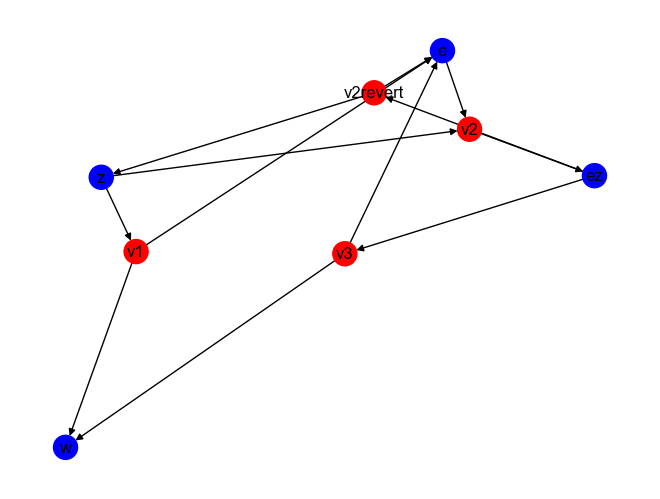

In [8]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [9]:
description_path = 'description_reaction1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

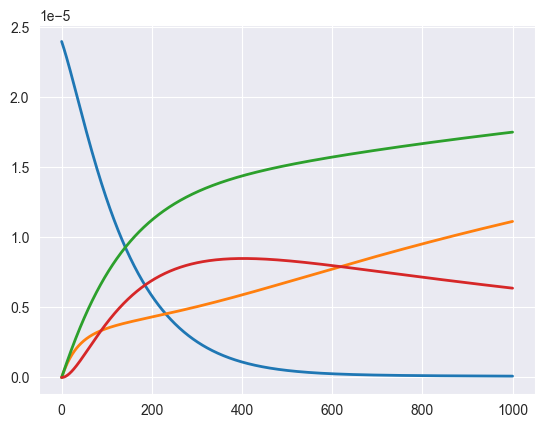

       time,         [z],         [e],         [w],        [ez]
 [[       0,     2.4e-05,           0,           0,           0],
  [   1.001,  2.3903e-05, 9.47644e-08, 9.59024e-08, 1.13797e-09],
  [   2.002, 2.38041e-05, 1.86915e-07, 1.91414e-07, 4.49927e-09],
  [   3.003, 2.37035e-05, 2.76524e-07, 2.86528e-07, 1.00047e-08],
  [   4.004, 2.36012e-05, 3.63663e-07,  3.8124e-07,  1.7577e-08],
  [ 5.00501, 2.34973e-05, 4.48408e-07, 4.75544e-07, 2.71361e-08],
  [ 6.00601,  2.3392e-05, 5.30829e-07, 5.69435e-07,  3.8606e-08],
  [ 7.00701, 2.32852e-05, 6.10994e-07, 6.62907e-07, 5.19137e-08],
  [ 8.00801, 2.31771e-05, 6.88969e-07, 7.55957e-07, 6.69879e-08],
  [ 9.00901, 2.30677e-05, 7.64821e-07,  8.4858e-07, 8.37596e-08],
  [   10.01, 2.29571e-05, 8.38611e-07, 9.40772e-07, 1.02161e-07],
  [  11.011, 2.28453e-05, 9.10402e-07, 1.03253e-06, 1.22128e-07],
  [  12.012, 2.27326e-05, 9.80253e-07, 1.12385e-06, 1.43596e-07],
  [  13.013, 2.26188e-05, 1.04822e-06, 1.21473e-06, 1.66504e-07],
  [  14.014,

In [10]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000092.xml')

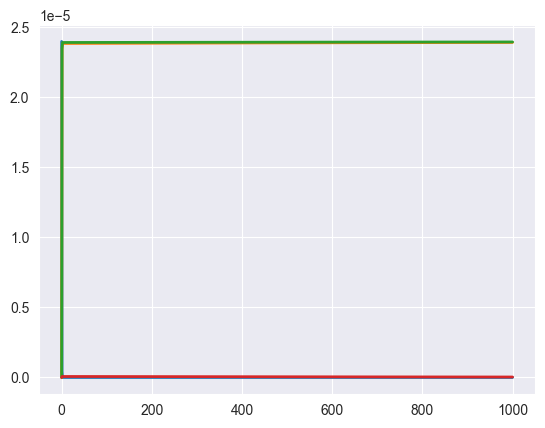

       time,         [z],         [e],         [w],        [ez]
 [[       0,     2.4e-05,           0,           0,           0],
  [   1.001, 4.29991e-07, 2.34323e-05, 2.35011e-05, 6.88675e-08],
  [   2.002, 7.66357e-09, 2.38497e-05,  2.3921e-05, 7.12958e-08],
  [   3.003, 1.40161e-10, 2.38573e-05, 2.39286e-05,  7.1287e-08],
  [   4.004, 6.14864e-12, 2.38575e-05, 2.39288e-05, 7.12344e-08],
  [ 5.00501, 3.75886e-12, 2.38576e-05, 2.39288e-05,  7.1181e-08],
  [ 6.00601, 3.71354e-12, 2.38577e-05, 2.39289e-05, 7.11277e-08],
  [ 7.00701, 3.70997e-12, 2.38578e-05, 2.39289e-05, 7.10744e-08],
  [ 8.00801, 3.70717e-12,  2.3858e-05,  2.3929e-05, 7.10211e-08],
  [ 9.00901, 3.70441e-12, 2.38581e-05,  2.3929e-05, 7.09679e-08],
  [   10.01, 3.70163e-12, 2.38582e-05, 2.39291e-05, 7.09148e-08],
  [  11.011, 3.69887e-12, 2.38583e-05, 2.39291e-05, 7.08616e-08],
  [  12.012,  3.6961e-12, 2.38584e-05, 2.39292e-05, 7.08085e-08],
  [  13.013, 3.69333e-12, 2.38585e-05, 2.39292e-05, 7.07555e-08],
  [  14.014,

In [11]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000092_reaction1_100x.xml')

In [12]:
species = description['species']
species

['z', 'e', 'w', 'ez']

In [13]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [14]:
final_normal

[1.00000000e+03 9.63360897e-08 1.11462360e-05 1.75249499e-05
 6.37870598e-06]

In [15]:
temp = final_concentrations_normal[1]
temp

[2.4e-05 0.0e+00 0.0e+00 0.0e+00]

In [16]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

z
final normal:  9.633608968643374e-08 final altered:  1.7640741024768178e-12 delta:  -9.633432561233127e-08 relative delta  -0.9999816883360305 initial concentration:  2.4e-05 delta1 0.004013930233847136 delta2 0.9999816883360305
e
final normal:  1.1146235966748172e-05 final altered:  2.3932406100081982e-05 delta:  1.278617013333381e-05 relative delta  1.1471289654622372 initial concentration:  0.0 delta1 0 delta2 1.1471289654622372
w
final normal:  1.7524949938530777e-05 final altered:  2.3966202168003964e-05 delta:  6.441252229473186e-06 relative delta  0.3675475394831967 initial concentration:  0.0 delta1 0 delta2 0.36754753948319663
ez
final normal:  6.3787059758879774e-06 final altered:  3.3796162074481763e-08 delta:  -6.3449098138134955e-06 relative delta  -0.9947017212892029 initial concentration:  0.0 delta1 0 delta2 0.9947017212892029


In [17]:
expected_results

{'z': 'decreased', 'e': 'increased', 'w': 'increased', 'ez': 'decreased'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

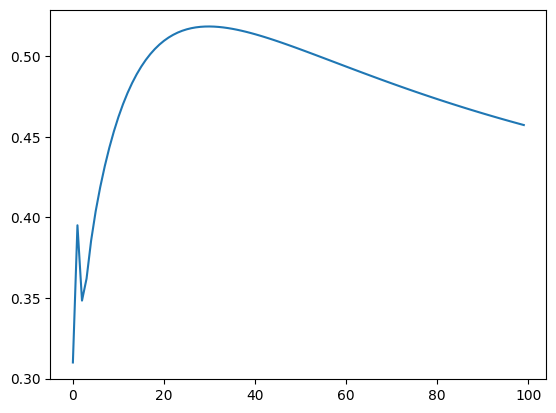

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [18]:
res = complete_tests.complete_tests2(
            'BIOMD0000000092.xml',
            'BIOMD0000000092_reaction1_100x.xml',
            'description_reaction1_altered',
            []
        )

In [25]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0.005)

Specie:  z expected result:  unchanged
confidence interval:  [0.44273060399600733, 0.44465487332468207]
Specie:  e expected result:  increased
confidence interval:  [0.5714092265680744, 0.5733492380097631]
Specie:  w expected result:  unchanged
confidence interval:  [0.4816510055957358, 0.4841566144023943]
Specie:  ez expected result:  decreased
confidence interval:  [0.5041043471501727, 0.5042050212970524]


In [20]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  4 correct experiments:  2 ratio:  0.5


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

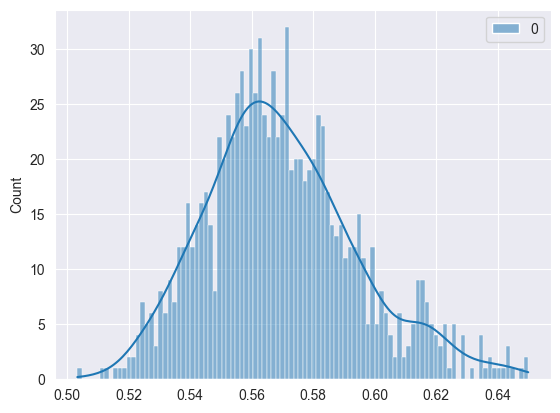

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)